In [ ]:
# in this notebook varya is trying to fit the model to classify DF and FF 
# based on some features of the catchments (such as morphometrics and/or climate stuff)

In [ ]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

# i will try to use this tutorial

# XGBoost models represent all problems as a regression predictive modeling problem that only takes numerical values as input. 


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import xgboost
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score
from sklearn.inspection import permutation_importance





### read data

 - make sure it has the target value X (1/0 -> DF/FF)
 - make sure its only 1 and 0 (not anything else) 
 - calculate correlations and scatter plots to look at how data looks 
 - make histograms for all features (to see how data looks like for different classes)
 - normalize with the z-score (just curious if it will change smth 

In [6]:
# read data: 

# in the copy table i have changed the FF/DF column 
# df = pd.read_csv('morphometrical_params.csv', sep = ';', index_col = 0)
df = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/10_datawrangl_formodel!!/morphometrical_params.csv', sep = ';', index_col = 0)
df = df[df.target.isin([1,0])]
df = df.drop('DN', axis = 1)
# reset FF/DF to 0 and 1
# all - flood, some - DF
# df['target'] = df.Name = 

In [7]:
# df.head()
# df.describe()
# sns.pairplot(df, hue='target', size=2.5) # this is the scatter plot for all values 


df['region_name'].value_counts()


tadjikistan       233
karakorum         169
eastTSH           107
chitral            89
interior tibet     84
langtang           32
nyanq              24
Name: region_name, dtype: int64

Text(0.5, 1.0, 'morphometry parameters')

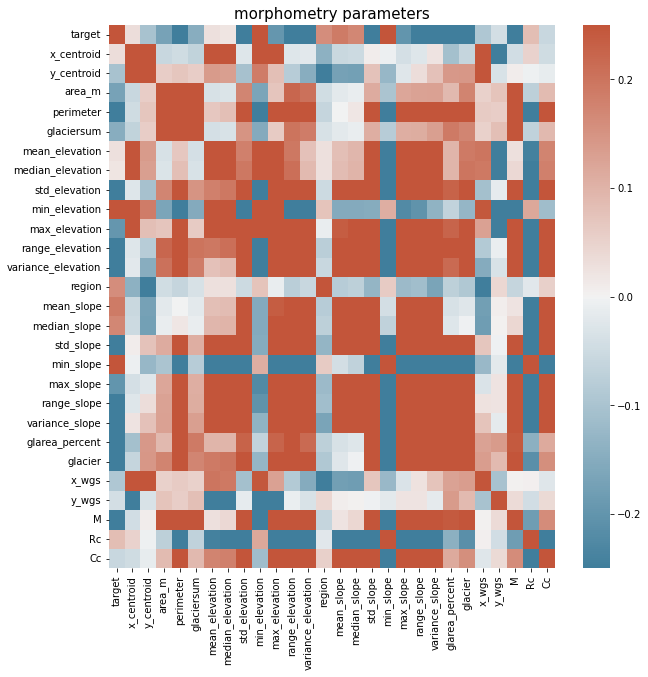

In [8]:
# correlations
df_corr = df.corr()


# plot

plt.figure(figsize=(10, 10))

# mask for the upper triangle
# mask = np.triu(np.ones_like(df_corr, dtype=bool))
# color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# heatmap 
# sns.heatmap(df_corr, cmap=cmap, mask = mask)
sns.heatmap(df_corr, cmap=cmap, vmin = -0.25, vmax = 0.25)
plt.title('morphometry parameters', fontsize = 15)



In [9]:
# scatter plot (stupid one for now) 
# g = sns.PairGrid(df, hue = 'target')
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)

# plt.savefig('params_scatter_sub.png', dpi = 300, bbox_inches = 'tight')


In [10]:
# scale the data with the z score: 
# df1 = df

In [11]:
# z score (#!!! maybe think about not including region number here) 

# df = df[['area_m', 'perimeter', 'glaciersum', 'mean_elevation', 'median_elevation', 
         # 'std_elevation', 'min_elevation', 'max_elevation', 'range_elevation',
         # 'variance_elevation', 'region', 'mean_slope', 'median_slope', 'std_slope', 
         # 'min_slope', 'max_slope', 'range_slope',
         # 'variance_slope', 'glarea_percent', 'glacier', 'x_wgs', 'y_wgs', 'M', 'Rc', 'Cc']]

# dfz = df.apply(zscore)
# dfz.head()

In [12]:
# dfz

# model stuff

(read for example this for the nice explanation: https://towardsdatascience.com/xgboost-python-example-42777d01001e)

In [13]:
# try for data scaled with z score:
# df = dfz
# df

In [14]:
# subset the data: 

df.columns

Index(['target', 'Name', 'x_centroid', 'y_centroid', 'area_m', 'perimeter',
       'glaciersum', 'mean_elevation', 'median_elevation', 'std_elevation',
       'min_elevation', 'max_elevation', 'range_elevation',
       'variance_elevation', 'region', 'region_name', 'mean_slope',
       'median_slope', 'std_slope', 'min_slope', 'max_slope', 'range_slope',
       'variance_slope', 'glarea_percent', 'glacier', 'x_wgs', 'y_wgs', 'M',
       'Rc', 'Cc'],
      dtype='object')

In [49]:
x_columns = ['area_m', 'perimeter', 'glaciersum', 'mean_elevation', 'median_elevation', 
         'std_elevation', 'min_elevation', 'max_elevation', 'range_elevation',
         'variance_elevation', 'region', 'mean_slope', 'median_slope', 'std_slope', 
         'max_slope', 'range_slope',
         'variance_slope', 'glarea_percent', 'glacier', 'M', 'Rc', 'Cc']
y_column = ['target']

In [50]:
# ------- split data into X and y
X = df[x_columns]
y = df[y_column]

In [51]:
# ------- split to train test: 

seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [52]:
## ----- model parameters 
print('default xgboost parameters:')
# xgboost.XGBClassifier().get_params()

# hyperparameters tuning example here:
# https://github.com/harsh1kumar/learning/blob/master/machine_learning/santander_trxn_prediction/07_trxn_pred_xgboost.ipynb

default xgboost parameters:


In [53]:
# 1. fit model to training data

model = XGBClassifier(n_estimators=1000)#, depth=2)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [54]:
# print(model)

In [55]:
# 5. Make Predictions - class:

# make predictions for test data
y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]

# evaluate predictions:
# accuracy = accuracy_score(y_test, predictions)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Accuracy — measures the fraction of correct predictions')
# Accuracy =(True Positive + True Negative)/(True Positive + True Negative+ False Positive+ False Negative)

  


Accuracy: 87.84%
Accuracy — measures the fraction of correct predictions


In [56]:
# predict probability (not class) 

probs = model.predict_proba(X_test)
# 2 columns: (1) 0 is true, (2) 1 is true
# therefore take the 2nd column:
probs = probs[:,1]



In [57]:
# random guess: 

print('random guess chanses with this data split: %.2f%%' % (555/738 * 100))#df/total 

random guess chanses with this data split: 75.20%


### model evaluation/validation stuff: (todo)

(read some more stuff here: https://medium.com/analytics-vidhya/10-essential-ways-to-evaluate-machine-learning-model-performance-6bf6e11f9502)

 - ROC curve and AUC 
 - precision/recall curve 
 - F1 score 
 - confusion matrix
 - cross validation( k10 -?)
 
 - hyperparameters: how many estimators, how many trees ect (see this for example: https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/) 
 
 

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

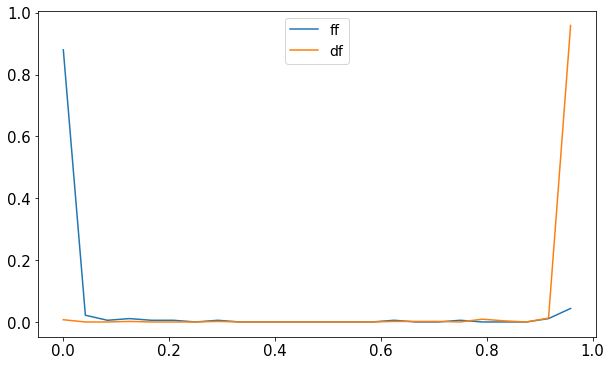

In [58]:
# ------- probability distributions plot:

# calculate probabilities 
# split into 2 classes 

debris = df[df.target.isin([1,])] # df
flood = df[df.target.isin([0,])]  # ff 

# split data into X and y
Xdebris = debris[x_columns]
ydebris = debris[y_column]

Xflood = flood[x_columns]
yflood = flood[y_column]

# debris:
dfprobs = model.predict_proba(Xdebris)
dfprobs = dfprobs[:,1]
# floods:
ffprobs = model.predict_proba(Xflood)
ffprobs = ffprobs[:,1]



# ------- histograms (normalized)

fig, ax = plt.subplots(figsize = (10,6))
# normalize histogram (example)
h, e = np.histogram(ffprobs, bins=np.linspace(0, 1, 25))
ax.plot(e[:-1], h/h.sum(), label = 'ff')

hd, ed = np.histogram(dfprobs, bins=np.linspace(0, 1, 25))
ax.plot(ed[:-1], hd/hd.sum(), label = 'df')

plt.legend(fontsize = 14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# this "histogram" plot shows the distribution of the "predicted" probabilities per class 
# default threshold to classify things is 50%

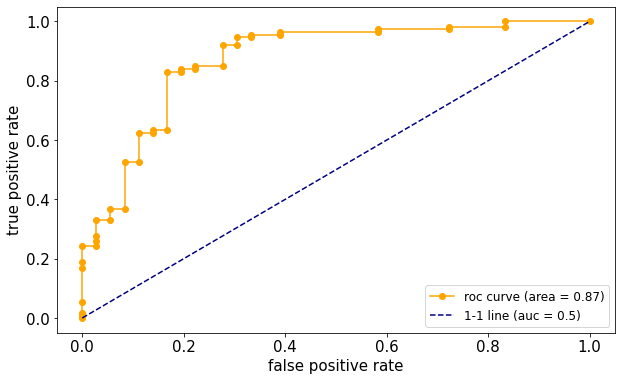

In [59]:
### ------ ROC curve: 
# plot of the false positive rate (x-axis) мы the true positive rate (y-axis) 
# for a number of different candidate threshold values between 0.0 and 1.0. 
# (in other way, it plots the false alarm rate versus the hit rate)
# the default probability for classification is 50% 
# this curve shows what would FPrate and TPrate have been, if the threshold was different
# A model with no skill is represented at the point (0.5, 0.5).
# A model with no skill at each threshold is represented by a diagonal 1-1 line and has an AUC of 0.5.

# ROC shows the ability of the model to predict a higher score for positive examples as compared to negative examples.

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)


fig, ax = plt.subplots(figsize = (10,6))
plt.plot(fpr, tpr, color = 'orange', marker='o', label = 'roc curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label = '1-1 line (auc = 0.5)')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate',fontsize=15)
plt.legend(fontsize=12)



In [60]:
## ------- confusion matrix: 
# (table that is used to define the performance of a classification algorithm)
# TP | FN
# --- ---
# FP | TN


confmatrix = confusion_matrix(y_test, y_pred)
print('confusion matrix: \n', confmatrix)

# 25+11+7+105

confusion matrix: 
 [[ 24  12]
 [  6 106]]


In [61]:
## ----- precision

precision = precision_score(y_test, y_pred)
print('precision score:', round(precision, 3))
# print(' measures the fraction of actual positives among those examples that are predicted as positive.
# print('It shows the probability that a predicted ‘Yes’ is actually a ‘Yes’')
print('precision = True Positive/True Positive+False Positive')
    

precision score: 0.898
precision = True Positive/True Positive+False Positive


In [62]:
### ------ f1 score 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

f1score = f1_score(y_test, y_pred)
print('f1 score:', round(f1score, 3))
print('f1score: F1 = 2 * (precision * recall) / (precision + recall)')

f1 score: 0.922
f1score: F1 = 2 * (precision * recall) / (precision + recall)


In [63]:
### --------- recall score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# Recall — measures how many actual positives were predicted as positive.
# It is the probability that an actual ‘Yes’ case is predicted correctly

recallscore = recall_score(y_test, y_pred)
print('recall score:', recallscore)
print('recall score: tp / (tp + fn)')

recall score: 0.9464285714285714
recall score: tp / (tp + fn)


In [64]:
# ----------- k-Fold Cross Validation


kfold = KFold(n_splits=10)#, random_state=7, shuffle=True)
results = cross_val_score(model, X, y, cv=kfold)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# k fold splits the data to pieces ('folds') and then trains and tests the model on k-1 folds (leaving one "out") 
# this way the accuracy that you get in the end is the mean value of the "each" training and testing thing
# basically there is a new "model" created fot each round of k-1 folds 

Accuracy: 84.55% (3.67%)


### model meaning: 

 - what features are important for the model: gain and weight (plots here) 

<AxesSubplot:>

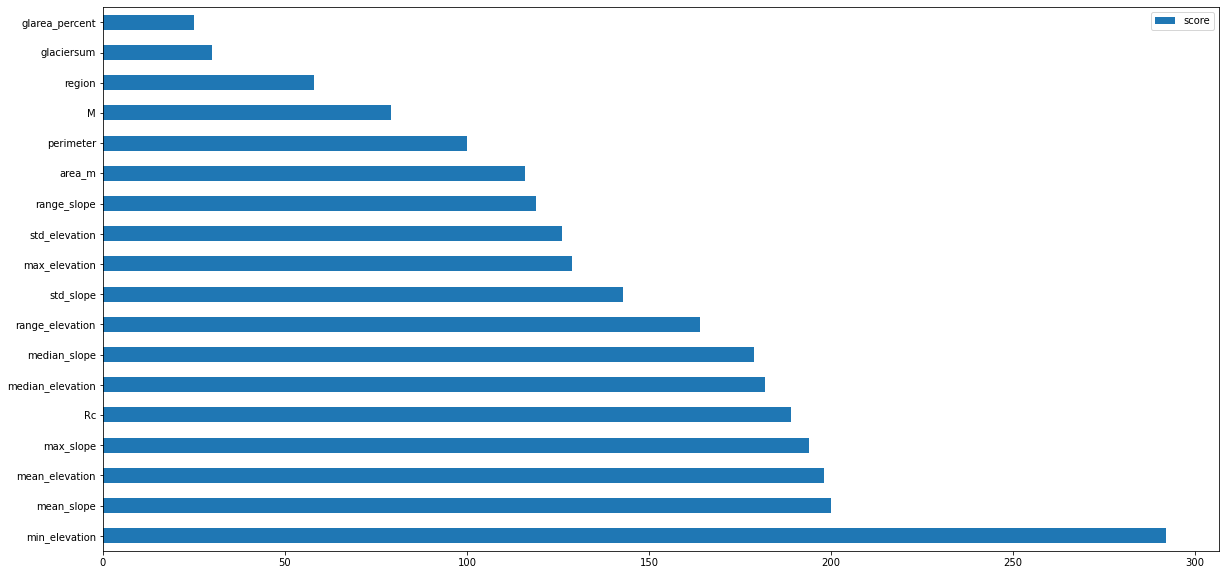

In [79]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

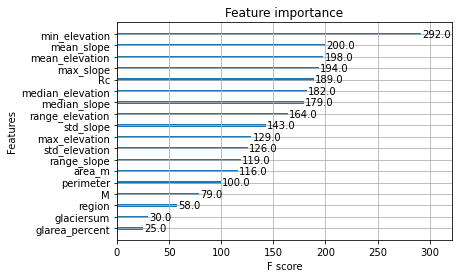

In [78]:
# plot feature importance

plot_importance(model)

In [32]:
# forest_importances

In [ ]:
## overall todo: 
# - play around with model tuning and make sure you have optimal hyperparameters (all these model evaluation plots etc) 
# - evaluation 
# meaning things 